## Reading data

In [1]:
import pyreadr
import sklearn
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import shap
import numpy as np
shap.initjs()


train = pyreadr.read_r('hmc_train.Rda')['train'] 
valid = pyreadr.read_r('hmc_valid.Rda')['valid']


def xy_split(data, y_name="PURCHASE"):
    return data.drop([y_name], axis=1), data[y_name]
X_train, Y_train = xy_split(train)
X_valid, Y_valid = xy_split(train)


## Training boosting model

In [2]:
xgmodel = XGBClassifier(max_depth=13,
                          objective='binary:logistic',
                        gamma=0.1)
xgmodel.fit(X_train, Y_train, verbose=True)
xg_predictions = xgmodel.predict(X_train)
valid_score = xgmodel.score(X_valid, Y_valid)
print("xgboost valid score {}".format(valid_score))


xgboost valid score 0.997


## Training linear model

In [3]:
logmodel = LogisticRegression(max_iter=1000, solver='lbfgs', C=3)
logmodel.fit(X_train, Y_train)
log_predictions = xgmodel.predict(X_train)
log_score = logmodel.score(X_valid, Y_valid)
print("logistic valid score {}".format(log_score))

logistic valid score 0.8003


lbfgs failed to converge. Increase the number of iterations.


## Ploting SHAP values for Tree model

In [4]:
explainer = shap.TreeExplainer(xgmodel)
xg_shap_values = explainer.shap_values(X_train.iloc[:100, :])
shap.force_plot(explainer.expected_value, xg_shap_values[0, :], X_train.iloc[0, :])
## restart notebook to see this plot (uses js)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


#### Shap values for first observation: positive are driving predition towards PURCHASE=1, on the contrar\y negative are driving it towards PURCHASE=0. Second row represents values of those features

In [5]:
print("prediction = {}".format(xg_predictions[0]))
pd.DataFrame(np.array([xg_shap_values[0, :], X_train.iloc[0, :]]), columns=list(X_train.columns))

prediction = 0.0


,TREATMENT,M_SNC_MST_RCNT_ACT_OPN,TOT_HI_CRDT_CRDT_LMT,RATIO_BAL_TO_HI_CRDT,AGRGT_BAL_ALL_XCLD_MRTG,N_OF_SATISFY_FNC_REV_ACTS,AVG_BAL_ALL_FNC_REV_ACTS,N_BANK_INSTLACTS,M_SNCOLDST_BNKINSTL_ACTOPN,N_FNC_INSTLACTS,...,D_REGION_A,D_REGION_B,D_REGION_C,D_NA_M_SNC_MST_RCNT_ACT_OPN,D_NA_AVG_BAL_ALL_FNC_REV_ACTS,D_NA_M_SNCOLDST_BNKINSTL_ACTOPN,D_NA_M_SNC_OLDST_MRTG_ACT_OPN,D_NA_M_SNC_MST_RCNT_MRTG_DEAL,D_NA_RATIO_PRSNL_FNC_BAL2HICRDT,UNIQUE_ID
0,0.105977,-0.210674,0.178878,0.108508,-0.040546,-0.028286,-0.002366,-0.00663,-0.015194,0.054301,...,-0.520172,0.028988,0.000245,0.001646,-0.002225,0.000028,0.003355,0.000006,-0.001201,0.009522
1,1.000000,92.000000,24300.000000,5.000000,1214.000000,0.000000,1767.197203,0.00000,99.789583,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


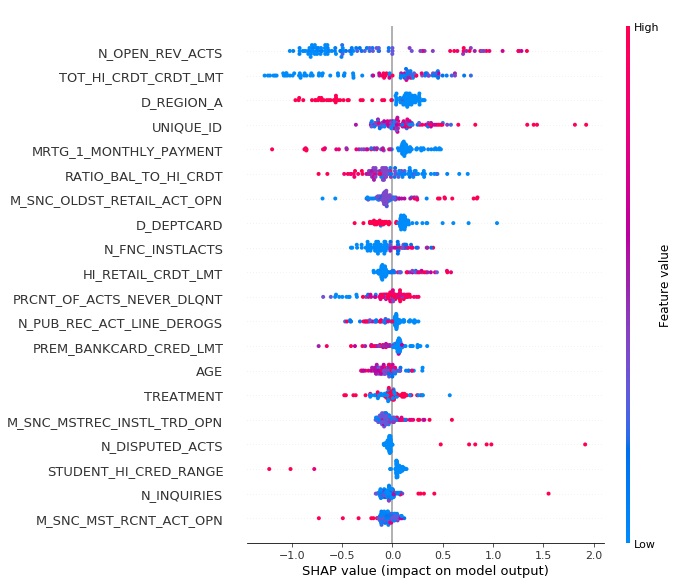

In [6]:
shap.summary_plot(xg_shap_values, X_train.iloc[:100, :], feature_names=list(X_train.columns))

## Plotting SHAP Values for linear model

In [7]:
explainer = shap.LinearExplainer(logmodel,  X_train)
log_shap_values = explainer.shap_values(X_train.iloc[:100, :])
shap.force_plot(explainer.expected_value, log_shap_values[0, :], X_train.iloc[0, :])
## restart notebook to see this plot (uses js)

#### Shap values for first observation: positive are driving predition towards PURCHASE=1, on the contrary negative are driving it towards PURCHASE=0. Second row represents values of those features

In [8]:
print("prediction = {}".format(log_predictions[0]))
pd.DataFrame(np.array([log_shap_values[0, :], X_train.iloc[0, :]]), columns=list(X_train.columns))

prediction = 0.0


,TREATMENT,M_SNC_MST_RCNT_ACT_OPN,TOT_HI_CRDT_CRDT_LMT,RATIO_BAL_TO_HI_CRDT,AGRGT_BAL_ALL_XCLD_MRTG,N_OF_SATISFY_FNC_REV_ACTS,AVG_BAL_ALL_FNC_REV_ACTS,N_BANK_INSTLACTS,M_SNCOLDST_BNKINSTL_ACTOPN,N_FNC_INSTLACTS,...,D_REGION_A,D_REGION_B,D_REGION_C,D_NA_M_SNC_MST_RCNT_ACT_OPN,D_NA_AVG_BAL_ALL_FNC_REV_ACTS,D_NA_M_SNCOLDST_BNKINSTL_ACTOPN,D_NA_M_SNC_OLDST_MRTG_ACT_OPN,D_NA_M_SNC_MST_RCNT_MRTG_DEAL,D_NA_RATIO_PRSNL_FNC_BAL2HICRDT,UNIQUE_ID
0,-0.000007,-0.236833,-0.127086,0.10291,0.016613,-0.000061,-0.000126,-0.000083,0.000515,-0.000117,...,-0.000033,0.000003,-8.311159e-07,0.000007,-0.000021,-0.000029,-0.000031,-0.000003,-0.000013,-0.037927
1,1.000000,92.000000,24300.000000,5.00000,1214.000000,0.000000,1767.197203,0.000000,99.789583,1.000000,...,1.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


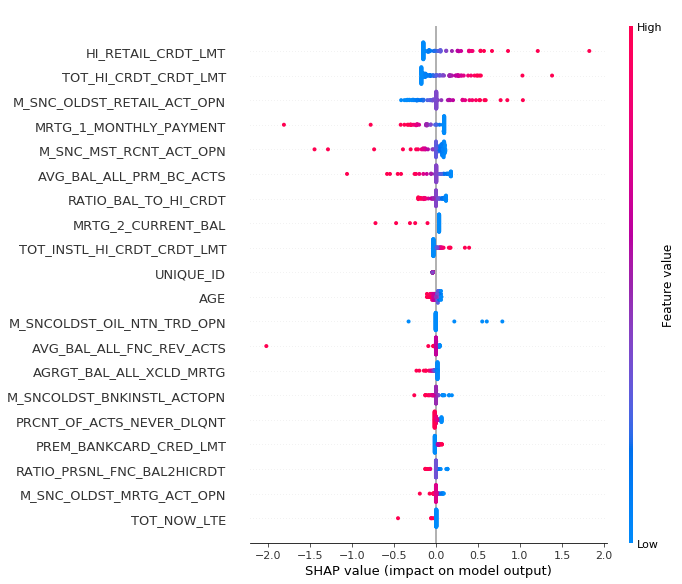

In [9]:
shap.summary_plot(log_shap_values, X_train.iloc[:100, :], feature_names=list(X_train.columns))

## Analysis
Different most important variables (it's easy to see on the plot they're highy variant, so probably first two have different values):

In [10]:
most_important = lambda i: X_train.columns[np.argmax(xg_shap_values[i])]
print("Most important feature for first observation: {}".format(most_important(0)))
print("Most important feature for second observation: {}".format(most_important(1)))

Most important feature for first observation: MRTG_1_MONTHLY_PAYMENT
Most important feature for second observation: N_OPEN_REV_ACTS


Considering the uplift modelling nature of the problem, i'll focus most on variable "TREATMENT".

In [11]:
treatment_col = X_train.columns.get_loc("TREATMENT")
print("Treatment influence on second customer: {}".format(xg_shap_values[1, treatment_col]))
print("Treatment influence on eleventh customer: {}".format(xg_shap_values[10, treatment_col]))

Treatment influence on second customer: 0.5691110491752625
Treatment influence on eleventh customer: -0.14805778861045837


Above example proves nonlinearity of the data which is a reason for logistic regression to have such a low score of 0.80 (because xgboost model have 0.997 acc on valid, i can safely assume it's a good estimation). Same conclusions may apear looking at variable importance plot - sometimes treatment have positive and sometimes negative influence. This also argrees with the uplift modelling theory (which is nonlinear itself), that some customers are "sleeping dogs" and we shouldn't wake them up.